# dev njitsu

In [1]:
%matplotlib inline
from lib.my_initialization import *
%autocall 1
%load_ext autoreload
%autoreload 2

Automatic calling is: Smart


# the slow, dissapative ESVI routine (forward euler integration/ FEI)

In [176]:
os.chdir(nb_dir)
# input_file_name = f'../data/spherical_meshes/spherical_mesh_64.stl'input_file_name = f'../data/spherical_meshes/spherical_mesh_64.stl'
input_file_name = f'../data/spherical_meshes/spherical_mesh_1000.stl'
tme = 0.
mass_density=1.
dict_values_system = initialize_system(input_file_name, time_initial=tme, mass_density=mass_density)
locals().update(dict_values_system)
print(list(dict_values_system.keys()))

#define Lamé parameters
mu = 1.; lam = 1.; 
#define coefficient for Rayleigh damping
gamma = 1.;

#define adaptive time stepping absolute tolerances
atol_x = 1e-4; atol_v = 1e-4; 
btol_x = 1e-12; btol_v = 1e-12; 

#get method of computing elastic forces 
zero_mat = np.zeros((4,3))
# calc_P = get_calc_P(mu, lam)
compute_nodal_damping_forces  = get_compute_nodal_damping_forces(mu,lam,gamma)
comp_nodal_elastic_forces = get_comp_nodal_elastic_forces(mu, lam)

elements = element_array_index
vertices = node_array_position

N_elements = elements.shape[0]
N_vertices = vertices.shape[0]

momentum = node_array_momentum.copy()

# #perturb momentum in the outward x direction and let it run overnight with a small timestep
# momentum_scale = 0.001
# momentum[:,0] = momentum_scale * vertices[:,0]
# velocities = momentum.copy()
# for j in range(N_vertices):
#     velocities[j] /= node_array_mass[j]
    
#perturb momentum in the outward x direction and let it run overnight with a small timestep
velocities = momentum.copy()
for j in range(N_vertices):
    velocities[j] /= node_array_mass[j]
v_scale = 1
velocities[:,0] = v_scale * vertices[:,0].copy()

#initialize containers of measures
volume_lst = []
tme_lst = []

face_normals all zero, ignoring!


['element_array_time', 'element_array_index', 'element_array_mass', 'element_array_volume', 'element_array_inverse_equilibrium_position', 'node_array_equilibrium_position', 'node_array_time', 'node_array_position', 'node_array_momentum', 'node_array_mass', 'node_array_volume']


In [3]:
# #TODO: wrap this in something like def explicit_synchronous(Q, V, M, elements, X0, t0, tf, stepsize):
# t0 = tme
# tf = 0.01#10#1.#0.001#.0019
# stepsize = 0.001#0.0.001 # 0.001 worked for tme to 2 but not 4

# #push all K finite elements into the queue at initial time t0
# queue = PriorityQueue()# queue = list()
# #initialize all elemental times to the same time value, t0, and push all elements to queue
# tauK = t0+0.*element_array_time
# for K_index in list(range(N_elements)):
#     tauK[K_index] = t0
#     queue.put((t0, K_index))#     queue.append((t0, K_index)) 
#     # tK2     = t0 # _compute_time(K, t0, stepsize, num_steps)

# # initialize nodal times to initial time t0
# tau = t0 + 0. * node_array_time

# #iterate over the elements in time.  
# #do until priority queue is empty
# # while len(queue) > 0:
# old_vertices = vertices.copy() 
# while not queue.empty():
#     #extract next element
#     t, K_index = queue.get()#pop(queue)
#     if t<=tf:
#         #synchronous time updates
#         #update node positions
#         Ka = elements[K_index]
#         K_vertices = vertices[Ka]
#         K_velocities = velocities[Ka]
#         for a in Ka:
#             vertices[a] = vertices[a] + velocities[a] * (t - tau[a])
#         #update node times
#         for a in Ka:
#             tau[a] = t

#         #compute the nodal forces for each tetrahedral
#         K_W = compute_element_volume(node_array_position=vertices, element_array_index=elements, K_index=K_index)
#         Bm  = element_array_inverse_equilibrium_position[K_index]
#         Ds  = get_D_mat(K_vertices)
#         fe   = comp_nodal_elastic_forces(K_W, Bm, Ds, f_out = zero_mat.copy())
#         fd   = compute_nodal_damping_forces(K_velocities, Ds, K_W, Bm, delta_f=zero_mat.copy())

#         #TODO(later): include any other forces, such as nodal forces, pressure forces, etc.
#         #net nodal forces
#         force = fe + fd
        
#         #update node velocities 
#         for j, a in enumerate(Ka):
#             velocities[a] = velocities[a] + ( (t - tauK[K_index]) / node_array_mass[a]) * force[j]
# #             velocities[a] = velocities[a] + ( (t - tauK[K_index]) / node_array_mass[a]) * force[j]
        
#         #TODO(later): if node is not a boundary node, set velocity to zero
#         #update element's time
#         tauK[K_index] = t
#         #compute next time for element's evaluation
#         tKnext = t + stepsize #_compute_next_time(K, t, stepsize)
        
#         #Schedule K for next update
#         queue.put((tKnext, K_index))#push( queue, (tKnext, K_index) )
        
#         #if a new time has been observed, measure the old_mesh volume. record volume and tme. update the old_mesh and time
#         if t>tme:
#             volume = compute_net_volume(old_vertices, elements)
#             volume_lst.append(volume)
#             tme_lst.append(tme)
#             #suppose synchronous time stepping
#             tme = t
#             old_vertices = vertices.copy()   

#             #synchronize all nodal positions with current time, tf
# for K_index in range(N_elements):
#     Ka = elements[K_index]
#     for a in Ka:
#         vertices[a] = vertices[a] + velocities[a] * (tf - tau[a])
#     #update node times
#     for a in Ka:
#         tau[a] = tf
# #update momentum
# for j in range(N_vertices):
#     node_array_momentum[j] = node_array_mass[j] * velocities[j]
    
# #update synchronous time
# tme = tf

# #Bottom Line Up Front (BLUF)
# beep(3)
# print(tf-t0)
# print(stepsize)

# the suspects to njit are already fast.  the priority queue overhead appears to be the limiting reagent

In [4]:
#compute the nodal forces for each tetrahedral
K_index = 7
Ka = elements[K_index]
K_vertices = vertices[Ka]
K_velocities = velocities[Ka]
K_W = compute_element_volume(node_array_position=vertices, element_array_index=elements, K_index=K_index)
Bm  = element_array_inverse_equilibrium_position[K_index]
Ds  = get_D_mat(K_vertices)
fe   = comp_nodal_elastic_forces(K_W, Bm, Ds, f_out = zero_mat.copy())
fd   = compute_nodal_damping_forces(K_velocities, Ds, K_W, Bm, delta_f=zero_mat.copy())

## (my PriorityQueue is not naively njit'able)

In [5]:
# from queue import PriorityQueue

# q = PriorityQueue()

# q.put((4, 'Read'))
# q.put((2, 'Play'))
# q.put((5, 'Write'))
# q.put((1, 'Code'))
# q.put((3, 'Study'))

# while not q.empty():
#     next_item = q.get()
#     print(next_item)

In [6]:
# from numba import njit
# @njit
# def foo():
#     q = PriorityQueue()
#     pass

# show a heap datastructure is njit'able

In [7]:
from heapq import heappush, heappop
from numba import njit

In [8]:
@njit#t(nopython=True)
def test_it():
    heap = [(2.,0.,[1,2,3])]
    item = (1.9,2.,[1,2])
    heappush(heap, item)
    item = (2.1,2.,[1,2])
    heappush(heap, item)
    ret = heappop(heap)
    print(ret)
    ret = heappop(heap)
    print(ret)

In [9]:
test_it()

(1.9, 2.0, [1, 2])
(2.0, 0.0, [1, 2, 3])


In [10]:
heap = [(2.,0.,[1,2,3])]
item = (1.9,2.,[1,2])
heappush(heap, item)
item = (2.1,2.,[1,2])
heappush(heap, item)
ret = heappop(heap)
print(ret)
ret = heappop(heap)
print(ret)

(1.9, 2.0, [1, 2])
(2.0, 0.0, [1, 2, 3])


# show a vague cartoon of an AVI is njit'able with ^that heap datastructure

In [11]:
import heapq

In [12]:
#TODO: first make a vague cartoon of an AVI is njit'able
@njit
def foo():
    N_tasks = 7
    item_lst = [(-i,1.,0) for i in range(N_tasks)] 
    heapq.heapify(item_lst)

    #integrate up to time tf and then synchronize the configurations
    tf = N_tasks*2
    while len(item_lst)>0:
        item = heapq.heappop(item_lst)
        t,h,K_index = item
        if t<=tf:
            #(for each step case & comparing each stepcase):
            #get the configuration
            #update the vertices and vertex times to t (or some varient)
            #compute the forces
            #update the vertex velocities and elemental times
            #compare results for the stepcases
            #update the actual configuration with the results of the best stepcase
            #push the next task to the heap
            item = (t+1, 2.,0)
            heapq.heappush(item_lst, item)
    #synchronize all elemental configurations to the same time
    #measure observables
    return item

In [13]:
foo()

(15, 2.0, 0)

# njit the low-level constituent parts, starting with the lowest level parts

In [14]:
import inspect

## compute_element_volume

In [15]:
K_W = compute_element_volume(node_array_position=vertices, element_array_index=elements, K_index=K_index)

In [16]:
print(inspect.getsource(compute_element_volume))

@njit
def compute_element_volume(node_array_position, element_array_index, K_index):
	'''Example Usage: 
	X_inverse = compute_inverse_position(node_array_equilibrium_position, element_array_index, K_index)'''
	D_K = compute_D_mat(node_array_position, element_array_index, K_index)
	# X_inverse = np.linalg.inv(D_K)
	#undeformed volume of element
	W = np.abs(np.linalg.det(D_K)/6.)
	return W



In [17]:
print(inspect.getsource(compute_D_mat))

@njit
def compute_D_mat(node_array_position, element_array_index, K_index):
	K_vertices = node_array_position[element_array_index[K_index]] 
	D = get_D_mat(K_vertices)
	return D



In [18]:
print(inspect.getsource(get_D_mat))

@njit
def get_D_mat(K_vertices):
	x1  = K_vertices[0,0];y1 = K_vertices[0,1];z1 = K_vertices[0,2]
	x2  = K_vertices[1,0];y2 = K_vertices[1,1];z2 = K_vertices[1,2]
	x3  = K_vertices[2,0];y3 = K_vertices[2,1];z3 = K_vertices[2,2]
	x4  = K_vertices[3,0];y4 = K_vertices[3,1];z4 = K_vertices[3,2]
	D = np.array([
			  [x1-x4,x2-x4,x3-x4],
			  [y1-y4,y2-y4,y3-y4],
			  [z1-z4,z2-z4,z3-z4]])
	return D



In [19]:
# @njit
# def get_D_mat(K_vertices):
# 	x1  = K_vertices[0,0];y1 = K_vertices[0,1];z1 = K_vertices[0,2]
# 	x2  = K_vertices[1,0];y2 = K_vertices[1,1];z2 = K_vertices[1,2]
# 	x3  = K_vertices[2,0];y3 = K_vertices[2,1];z3 = K_vertices[2,2]
# 	x4  = K_vertices[3,0];y4 = K_vertices[3,1];z4 = K_vertices[3,2]
# 	D = np.array([
# 			  [x1-x4,x2-x4,x3-x4],
# 			  [y1-y4,y2-y4,y3-y4],
# 			  [z1-z4,z2-z4,z3-z4]])
# 	return D

In [20]:
# @njit
# def compute_D_mat(node_array_position, element_array_index, K_index):
# 	K_vertices = node_array_position[element_array_index[K_index]] 
# 	D = get_D_mat(K_vertices)
# 	return D

In [21]:
# @njit
# def compute_element_volume(node_array_position, element_array_index, K_index):
# 	'''Example Usage: 
# 	X_inverse = compute_inverse_position(node_array_equilibrium_position, element_array_index, K_index)'''
# 	D_K = compute_D_mat(node_array_position, element_array_index, K_index)
# 	# X_inverse = np.linalg.inv(D_K)
# 	#undeformed volume of element
# 	W = np.abs(np.linalg.det(D_K)/6.)
# 	return W

In [22]:
D = get_D_mat(K_vertices)

In [23]:
D_K = compute_D_mat(node_array_position=vertices, element_array_index=elements, K_index=K_index)

In [24]:
K_W = compute_element_volume(node_array_position=vertices, element_array_index=elements, K_index=K_index)

## comp_nodal_elastic_forces

In [25]:
print(inspect.getsource(comp_nodal_elastic_forces))

	@njit
	def comp_nodal_elastic_forces(K_W, Bm, Ds, f_out):
		F = Ds @ Bm
		P = calc_P(F)
		H = -K_W * P @ Bm.T
		H = H.T
		f_out[0] += H[0]
		f_out[1] += H[1]
		f_out[2] += H[2]
		f_out[3] += (-H[0] -H[1] -H[2])
		return f_out



In [26]:
comp_nodal_elastic_forces = get_comp_nodal_elastic_forces(mu, lam)

In [27]:
fe   = comp_nodal_elastic_forces(K_W, Bm, Ds, f_out = zero_mat.copy())

In [28]:
fe   = comp_nodal_elastic_forces(K_W, Bm, Ds, f_out = zero_mat.copy())

In [29]:
compute_nodal_damping_forces  = get_compute_nodal_damping_forces(mu,lam,gamma)

fd   = compute_nodal_damping_forces(K_velocities, Ds, K_W, Bm, delta_f=zero_mat.copy())


In [30]:
fd   = compute_nodal_damping_forces(K_velocities, Ds, K_W, Bm, delta_f=zero_mat.copy())


# don't njit the movie making.  That process will take roughly 40 minutes to create 2 minutes of video content at 40fps...  I'm okay with that.

# energy measurement

In [31]:
mass_of_K = element_array_mass[K_index]

In [32]:
comp_element_energy ( mass_of_K, K_velocities, K_W, Bm, Ds, mu, lam)

3.4441343989734264e-05

In [33]:
comp_element_energy ( mass_of_K, K_velocities, K_W, Bm, Ds, mu, lam)

3.4441343989734264e-05

# if I njit the whole mesh measurements, then everything should be good for high level njit'ing

In [34]:
compute_net_volume(vertices, elements)


4.164633994810831

In [36]:
compute_net_volume(vertices, elements)


4.164633994810831

In [37]:
compute_net_energy(N_elements, element_array_mass, velocities, vertices,
                              elements, element_array_inverse_equilibrium_position, mu, lam)

0.41954969589532776

In [38]:
compute_net_energy(N_elements, element_array_mass, velocities, vertices,
                              elements, element_array_inverse_equilibrium_position, mu, lam)

0.41954969589532776

In [35]:
comp_element_array_energy(N_elements, element_array_mass, velocities, vertices,
                              elements, element_array_inverse_equilibrium_position, mu, lam)

/Users/timothytyree/Documents/GitHub/adavi/nb/lib/measure/mesh_measures.py:30: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 2d, A))
  element_array_energy[K_index] = comp_element_energy(mass_of_K, K_velocities, K_W, Bm, Ds, mu, lam)


array([4.65148647e-05, 2.32691699e-05, 3.34268897e-05, ...,
       2.01333900e-05, 1.09409004e-05, 9.27826301e-06])

In [39]:
comp_element_array_energy(N_elements, element_array_mass, velocities, vertices,
                              elements, element_array_inverse_equilibrium_position, mu, lam)

array([4.65148647e-05, 2.32691699e-05, 3.34268897e-05, ...,
       2.01333900e-05, 1.09409004e-05, 9.27826301e-06])

# net force njitsu

In [40]:
#compute the nodal forces for each tetrahedral
K_W = compute_element_volume(node_array_position=vertices, element_array_index=elements, K_index=K_index)
Bm  = element_array_inverse_equilibrium_position[K_index]
Ds  = get_D_mat(K_vertices)
fe   = comp_nodal_elastic_forces(K_W, Bm, Ds, f_out = zero_mat.copy())
fd   = compute_nodal_damping_forces(K_velocities, Ds, K_W, Bm, delta_f=zero_mat.copy())

#TODO(later): include any other forces, such as nodal forces, pressure forces, etc.
#net nodal forces
force = fe + fd

In [47]:
# def get_compute_force(mu,lam,gamma):
#     compute_nodal_damping_forces  = get_compute_nodal_damping_forces(mu,lam,gamma)
#     comp_nodal_elastic_forces = get_comp_nodal_elastic_forces(mu, lam)
#     @njit
#     def compute_force(K_velocities, Ds, K_W, Bm, zero_mat):
#         """returns the net nodal forces for an element"""
#         fe   = comp_nodal_elastic_forces(K_W, Bm, Ds, f_out = zero_mat.copy())
#         fd   = compute_nodal_damping_forces(K_velocities, Ds, K_W, Bm, delta_f=zero_mat.copy())
#         force = fe + fd
#         return force
#     return compute_force

In [70]:
compute_force = get_compute_force(mu,lam,gamma)
compute_force(K_velocities, Ds, K_W, Bm, zero_mat)

array([[ 0.00038165,  0.00117242, -0.00049697],
       [-0.00481031, -0.00090432,  0.00022637],
       [-0.00026932, -0.00041377,  0.00159091],
       [ 0.00469798,  0.00014567, -0.0013203 ]])

In [67]:
a = 0.
for j in range(100000):
    a += compute_force(K_velocities, Ds, K_W, Bm, zero_mat)

In [68]:
a

array([[  38.16516944,  117.24236308,  -49.69745728],
       [-481.03051752,  -90.43222608,   22.63685829],
       [ -26.93234832,  -41.37708997,  159.09073511],
       [ 469.79769639,   14.56695297, -132.03013611]])

# dev a per element one step method and njit it

In [118]:
tau = node_array_time
tauK = element_array_time

In [119]:
K_index = 7

#compute the namespace of the force computation of the elemental configuration
Ka = element_array_index[K_index]
tau_of_K = tauK[K_index]
K_vertices = vertices[Ka]
K_velocities = velocities[Ka]
K_masses = node_array_mass[Ka]
K_tau = tau[Ka]
K_W = compute_element_volume(node_array_position=vertices, element_array_index=elements, K_index=K_index)
Bm  = element_array_inverse_equilibrium_position[K_index]
Ds  = get_D_mat(K_vertices)


In [132]:
# def get_compute_one_step_forward_euler_method(mu,lam,gamma):
#     compute_force = get_compute_force(mu,lam,gamma)
#     @njit
#     def compute_one_step_forward_euler_method(t, K_vertices, K_velocities, K_masses, K_tau, tau_of_K, Ds, Bm, K_W, zero_mat):
#         '''integrates the inputed element configuration up tot time t.  element time is not updated by this function.
#         also updates K_velocities, K_vertices, K_tau, to time t.'''
#         Na = 4 # number of tetrahedral nodes, which is 4
#         # t, K_index, vertices, velocities, Ka, tau, tauK, elements, element_array_inverse_equilibrium_position, zero_mat, node_array_mass):
#         #         Delta_x = np.multiply (K_velocities , (t - K_tau))
#         for a in range(Na):
#             K_vertices[a] = K_vertices[a] + K_velocities[a] * (t - K_tau[a]) #+ Delta_x[a]
#         #update node times
#         for a in range(Na):
#             K_tau[a] = t
#         #compute the nodal forces for the tetrahedral element
#         force = compute_force(K_velocities, Ds, K_W, Bm, zero_mat.copy())
#         # force = compute_force(K_velocities, Ds, K_W, Bm, zero_mat) #is this faster? also doesn't update zero_mat?
#         #        Delta_v = np.multiply ( (t - tau_of_K) / K_masses , force )
#         #update node velocities 
#         for a in range(Na):
#             K_velocities[a] = K_velocities[a] + (t - tau_of_K) / K_masses[a] * force[a] #+ Delta_v[a]
        
#         #TODO(later): if node is not a boundary node, set velocity to zero
#         #         return Delta_x, Delta_v
#     return compute_one_step_forward_euler_method

In [133]:
compute_one_step_forward_euler_method=get_compute_one_step_forward_euler_method(mu,lam,gamma)

In [134]:
print(K_vertices, K_velocities, K_masses, K_tau, tau_of_K)

[[ -11876.56275803  -17333.64538883   10918.02351634]
 [  99491.47276607   32484.98870086  -32036.30391532]
 [  22095.60846812   10212.53957775  -37111.21098642]
 [-241880.90805621  -34508.8776153   141759.59501336]] [[ 3.31652990e+07  4.74685839e+07 -3.59389213e+07]
 [-2.37034530e+08 -9.02646674e+07  1.02479977e+08]
 [-6.53487530e+07 -3.31047317e+07  1.13524958e+08]
 [ 5.95733876e+08  1.13186601e+08 -4.33473430e+08]] [0.00147413 0.00082212 0.00113599 0.00036965] [8.2 8.2 8.2 8.2] 0.0


In [135]:
compute_one_step_forward_euler_method(t, K_vertices, K_velocities, K_masses, K_tau, tau_of_K, Ds, Bm, K_W, zero_mat)

In [136]:
print(K_vertices, K_velocities, K_masses, K_tau, tau_of_K)

[[-3.98102354e+07 -5.69796343e+07  4.31376236e+07]
 [ 2.84540928e+08  1.08350086e+08 -1.23008009e+08]
 [ 7.84405993e+07  3.97358906e+07 -1.36267060e+08]
 [-7.15122532e+08 -1.35858430e+08  5.20309875e+08]] [[-9.09422592e+10 -1.31760493e+11  1.05737227e+11]
 [ 6.21104936e+11  2.49814688e+11 -2.94054286e+11]
 [ 1.82064413e+11  9.68321750e+10 -3.27864661e+11]
 [-1.57818631e+12 -3.27725785e+11  1.23988332e+12]] [0.00147413 0.00082212 0.00113599 0.00036965] [7. 7. 7. 7.] 0.0


verified that the original configuration is updated by compute_one_step_forward_euler_method

In [137]:
compute_one_step_forward_euler_method(t, K_vertices, K_velocities, K_masses, K_tau, tau_of_K, Ds, Bm, K_W, zero_mat)


In [125]:
print(K_vertices, K_velocities, K_masses, K_tau, tau_of_K)

[[-5.77472642 -0.21974694  0.27215671]
 [-5.65160492 -0.10365256  0.30321957]
 [-6.22915941 -0.13351224  0.2142964 ]
 [-6.30118951 -0.09593313  0.30064529]] [[  -9892.32335968  -14444.52136824    9098.12613303]
 [  82914.27030916   27070.91029451  -26697.1726124 ]
 [  18418.19802294    8510.56090833  -30926.18773568]
 [-201562.17238891  -28757.31806848  118132.74530673]] [0.00147413 0.00082212 0.00113599 0.00036965] [7. 7. 7. 7.] 0.0


In [126]:
compute_one_step_forward_euler_method(t+1.2, K_vertices, K_velocities, K_masses, K_tau, tau_of_K, Ds, Bm, K_W, zero_mat)


In [127]:
print(K_vertices, K_velocities, K_masses, K_tau, tau_of_K)

[[ -11876.56275803  -17333.64538883   10918.02351634]
 [  99491.47276607   32484.98870086  -32036.30391532]
 [  22095.60846812   10212.53957775  -37111.21098642]
 [-241880.90805621  -34508.8776153   141759.59501336]] [[ 3.31652990e+07  4.74685839e+07 -3.59389213e+07]
 [-2.37034530e+08 -9.02646674e+07  1.02479977e+08]
 [-6.53487530e+07 -3.31047317e+07  1.13524958e+08]
 [ 5.95733876e+08  1.13186601e+08 -4.33473430e+08]] [0.00147413 0.00082212 0.00113599 0.00036965] [8.2 8.2 8.2 8.2] 0.0


so, all configuration variables update except the elemental time (since it is a python primative and not a numpy array).  This must thus be done externally


# njit one element update with FEI, from K_index up until pushing to queue

In [146]:
# def get_one_step_forward_euler_method(mu,lam,gamma):
#     compute_one_step_forward_euler_method=get_compute_one_step_forward_euler_method(mu,lam,gamma)
#     @njit
#     def one_step_forward_euler_method(t, K_index, element_array_index, tauK, tau, 
#                                       vertices, velocities, node_array_mass, element_array_inverse_equilibrium_position):
#         #compute the namespace of the force computation of the elemental configuration
#         Ka = element_array_index[K_index]
#         tau_of_K = tauK[K_index]
#         K_tau = tau[Ka]
#         K_vertices = vertices[Ka]
#         K_velocities = velocities[Ka]
#         K_masses = node_array_mass[Ka]
#         Bm  = element_array_inverse_equilibrium_position[K_index]
#         K_W = compute_element_volume(node_array_position=vertices, element_array_index=elements, K_index=K_index)
#         Ds  = get_D_mat(K_vertices)
#         compute_one_step_forward_euler_method(t, K_vertices, K_velocities, K_masses, K_tau, tau_of_K, Ds, Bm, K_W, zero_mat) #updates nodal times
#         #update element's time
#         tauK[K_index] = t
#     return one_step_forward_euler_method

In [147]:
one_step_forward_euler_method = get_one_step_forward_euler_method(mu,lam,gamma)

In [149]:
K_index = 14
t = 14
one_step_forward_euler_method(t, K_index, element_array_index, tauK, tau, vertices, velocities, node_array_mass, element_array_inverse_equilibrium_position)

<ipython-input-146-02d5193feb9e>:16: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 2d, A))
  compute_one_step_forward_euler_method(t, K_vertices, K_velocities, K_masses, K_tau, tau_of_K, Ds, Bm, K_W, zero_mat) #updates nodal times


In [151]:
K_index = 14
t = 15
one_step_forward_euler_method(t, K_index, element_array_index, tauK, tau, vertices, velocities, node_array_mass, element_array_inverse_equilibrium_position)

In [164]:
K_index = 245
for t in np.linspace(18, 19, 50000):
    one_step_forward_euler_method(t, K_index, element_array_index, tauK, tau, vertices, velocities, node_array_mass, element_array_inverse_equilibrium_position)

In [161]:
# element_array_index, 
# tauK, tau, 
# vertices, velocities, 
# node_array_mass, element_array_inverse_equilibrium_position

(array([[ 0.82318336, -0.28679195,  0.49001995],
        [-0.61198336, -0.17415603, -0.77145708],
        [-0.46902016, -0.81415004, -0.34231538],
        ...,
        [-0.36995283, -0.31743564,  0.50062042],
        [-0.55663522, -0.13616795,  0.43350866],
        [-0.52032534, -0.180729  ,  0.46283292]]),
 array([[ 0.82318336, -0.        ,  0.        ],
        [-0.61198336, -0.        , -0.        ],
        [-0.46902016, -0.        , -0.        ],
        ...,
        [-0.36995283, -0.        ,  0.        ],
        [-0.55663522, -0.        ,  0.        ],
        [-0.52032534, -0.        ,  0.        ]]))

## I can now update an element with FEI about 50,000 times per second.

In [ ]:
K_index = 246
for t in np.linspace(18, 19, 50000):
    one_step_forward_euler_method(t, K_index, element_array_index, tauK, tau, vertices, velocities, node_array_mass, element_array_inverse_equilibrium_position)

In [ ]:
#TODO: first make a vague cartoon of an AVI is njit'able
# @njit
def foo():
    N_tasks = 7
    item_lst = [(-i,1.,0) for i in range(N_tasks)] 
    heapq.heapify(item_lst)

    #integrate up to time tf and then synchronize the configurations
    tf = N_tasks*2
    while len(item_lst)>0:
        item = heapq.heappop(item_lst)
        t,h,K_index = item
        if t<=tf:
            #(for each step case & comparing each stepcase):
            #get the configuration
            #update the vertices and vertex times to t (or some varient)
            #compute the forces
            #update the vertex velocities and elemental times
            #compare results for the stepcases
            #update the actual configuration with the results of the best stepcase
            #push the next task to the heap
            item = (t+1, 2.,0)
            heapq.heappush(item_lst, item)
    #synchronize all elemental configurations to the same time
    #measure observables
    return item

# njit an AVI up to time tf, given a list of initial times and stepsizes per element

In [46]:
os.chdir(nb_dir)
# input_file_name = f'../data/spherical_meshes/spherical_mesh_64.stl'input_file_name = f'../data/spherical_meshes/spherical_mesh_64.stl'
input_file_name = f'../data/spherical_meshes/spherical_mesh_1000.stl'
tme = 0.
mass_density=1.
dict_values_system = initialize_system(input_file_name, time_initial=tme, mass_density=mass_density)
locals().update(dict_values_system)
print(list(dict_values_system.keys()))

#define Lamé parameters
mu = 1.; lam = 1.; 
#define coefficient for Rayleigh damping
gamma = 1.;

#define adaptive time stepping absolute tolerances
atol_x = 1e-4; atol_v = 1e-4; 
btol_x = 1e-12; btol_v = 1e-12; 

#get method of computing elastic forces 
zero_mat = np.zeros((4,3))
# calc_P = get_calc_P(mu, lam)
# compute_nodal_damping_forces  = get_compute_nodal_damping_forces(mu,lam,gamma)
# comp_nodal_elastic_forces = get_comp_nodal_elastic_forces(mu, lam)

elements = element_array_index
vertices = node_array_position

N_elements = elements.shape[0]
N_vertices = vertices.shape[0]

#initialize stepsizes
stepsize_init = 0.001
element_array_stepsize = np.zeros_like(element_array_time) + stepsize_init

#perturb momentum in the outward x direction and let it run overnight with a small timestep
momentum = node_array_momentum.copy()
velocities = momentum.copy()
for j in range(N_vertices):
    velocities[j] /= node_array_mass[j]
v_scale = 1
velocities[:,0] = v_scale * vertices[:,0].copy()

#initialize containers of measures
volume_lst = []
energy_lst = []
tme_lst    = []

face_normals all zero, ignoring!


['element_array_time', 'element_array_index', 'element_array_mass', 'element_array_volume', 'element_array_inverse_equilibrium_position', 'node_array_equilibrium_position', 'node_array_time', 'node_array_position', 'node_array_momentum', 'node_array_mass', 'node_array_volume']


In [47]:
def get_integrate_system_explicit_synchronous(mu,lam,gamma):
    one_step_forward_euler_method = get_one_step_forward_euler_method(mu,lam,gamma)
    @njit
    def integrate_system_explicit_synchronous(tf, element_array_time, element_array_stepsize, 
                                             element_array_index, vertices, velocities, 
                                          node_array_mass, element_array_inverse_equilibrium_position):
        """integrate up to time tf with synchronous forward euler integration"""
        #initialize the queue by pushing all finite elements into the queue
        N_elements = element_array_stepsize.shape[0]
        queue = [(element_array_time[K_index],element_array_stepsize[K_index],K_index) for K_index in range(N_elements)]
        heapq.heapify(queue)

        tauK = element_array_time
        tau  = node_array_time
        #do until priority queue is empty
        while len(queue) > 0:
            t,h,K_index = heapq.heappop(queue)
            if t<=tf:
                t_previous = tauK[K_index]
                #TODO: for each stepcase: #(for the purpose of comparing each stepcase)
                #TODO: update the configuration arrays of each stepcase with the configuration for this element
                #timestep the configuration with forward euler integration
                one_step_forward_euler_method(t, K_index, element_array_index, 
                                              tauK, tau, vertices, velocities, 
                                              node_array_mass, 
                                              element_array_inverse_equilibrium_position)
                #update the elemental times
                tauK[K_index] = t

                #TODO: compare results for the stepcases. choose an h_next for the next time for element's evaluation
                stepsize_next = h
                t_next = t + stepsize_next
                #TODO: update the actual configuration with the results of the best stepcase
                element_array_stepsize[K_index] = stepsize_next
                #TODO: push the next task to the heap/priority queue
                heapq.heappush(queue, (t_next, stepsize_next, K_index))

        #synchronize all nodes  to the current time, tf.
        for K_index in range(N_elements):
            Ka = element_array_index[K_index]
            for a in Ka:
                vertices[a] = vertices[a] + velocities[a] * (tf - tau[a])
        return True
    return integrate_system_explicit_synchronous

In [49]:
#jit compile the forward time integration by integrating to the first stepsize
tf = stepsize_init # .001
integrate_system_explicit_synchronous = get_integrate_system_explicit_synchronous(mu,lam,gamma)
integrate_system_explicit_synchronous(tf, element_array_time, element_array_stepsize, 
                                         element_array_index, vertices, velocities, 
                                      node_array_mass, element_array_inverse_equilibrium_position)

<ipython-input-47-569b5ec9ae92>:23: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 2d, A))
  one_step_forward_euler_method(t, K_index, element_array_index,


True

In [51]:
beep(3)
print(np.isnan(vertices).any())
print(np.isnan(velocities).any())

False
False


In [52]:
tf = .1
integrate_system_explicit_synchronous(tf, element_array_time, element_array_stepsize, 
                                         element_array_index, vertices, velocities, 
                                      node_array_mass, element_array_inverse_equilibrium_position)

True

In [53]:
#measure observables
net_volume = compute_net_volume(vertices, element_array_index)
net_energy = compute_net_energy(N_elements, element_array_mass, velocities, vertices,
                              element_array_index, element_array_inverse_equilibrium_position, mu, lam)
#return 
net_volume, net_energy
        

(16.292805914944193, nan)

In [17]:
compute_net_energy(N_elements, element_array_mass, velocities, vertices,
                              elements, element_array_inverse_equilibrium_position, mu, lam)

nan

face_normals all zero, ignoring!
/usr/local/lib/python3.8/site-packages/tetgen/pytetgen.py:534: UserWarning: VTK 9 no longer accepts an offset array
  self._grid = pv.UnstructuredGrid(offset, cells, cell_type, self.node)


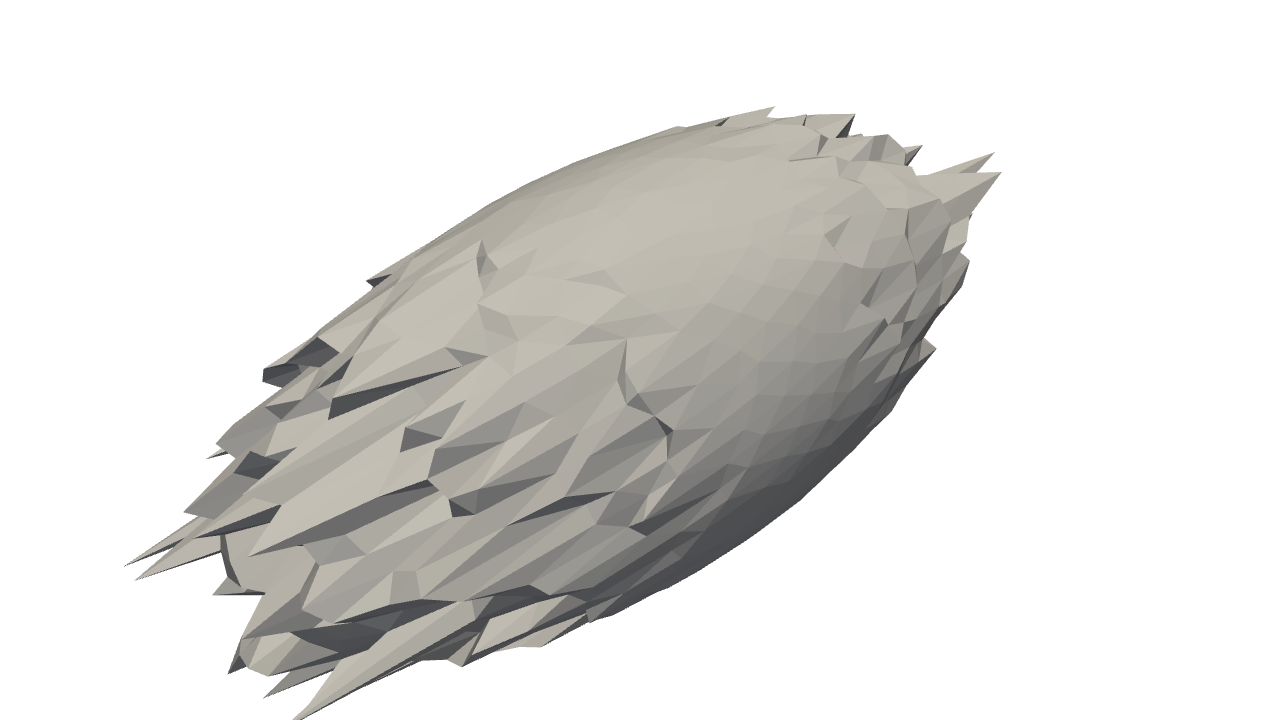

In [54]:
from lib.viewer.vtk_viewer_of_mesh import *

img = plot_mesh(vertices, input_file_name=input_file_name, darkmode=False)

In [1]:
        
#         #if a new time has been observed, measure the old_mesh volume. record volume and tme. update the old_mesh and time
#         if t>tme:
#             volume = compute_net_volume(old_vertices, elements)
#             volume_lst.append(volume)
#             tme_lst.append(tme)
#             #suppose synchronous time stepping
#             tme = t
#             old_vertices = vertices.copy()   

#             #synchronize all nodal positions with current time, tf
# for K_index in range(N_elements):
#     Ka = elements[K_index]
#     for a in Ka:
#         vertices[a] = vertices[a] + velocities[a] * (tf - tau[a])
#     #update node times
#     for a in Ka:
#         tau[a] = tf
# #update momentum
# for j in range(N_vertices):
#     node_array_momentum[j] = node_array_mass[j] * velocities[j]
    
# #update synchronous time
# tme = tf

# #Bottom Line Up Front (BLUF)
# beep(3)
# print(tf-t0)
# print(stepsize)

In [3]:
try:
    pass
except:
    pass